In [4]:
from SARA_cornell_funcs import *
import numpy as np
import matplotlib.pyplot as plt
import glob
import codecs
import sys
sys.path.append('/home/vandover/Documents/2020_CHESS_run/')
import pyFAI
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator as az
from xrdCalibFit import PoniFit, automask, ptt

In [8]:
meta[key]

{'FORMAT ': ['100'],
 'VERSION': ['15'],
 'HDRBLKS': ['15'],
 'TYPE   ': ['ADD', 'FRAME,', 'UNWARPED'],
 'SITE   ': [],
 'MODEL  ': ['Booster[A110080]', 'with', 'UMC151'],
 'USER   ': ['Lab', 'Manager'],
 'SAMPLE ': ['Commander', 'Sample', 'ID'],
 'SETNAME': ['UNKNOWN'],
 'RUN    ': ['0'],
 'SAMPNUM': ['0'],
 'TITLE  ': [],
 'NCOUNTS': ['5123599', '0'],
 'NOVERFL': ['-1', '5634', '0'],
 'MINIMUM': ['0'],
 'MAXIMUM': ['111'],
 'NONTIME': ['4601991'],
 'NLATE  ': ['857'],
 'FILENAM': ['20F39_Sb_1mm_theta_15_twotheta_20-55-5_30s004.gfrm'],
 'CREATED': ['29-Jul-2020', '21:40:01'],
 'CUMULAT': ['45.000000'],
 'ELAPSDR': ['45.000000'],
 'ELAPSDA': ['45.000000'],
 'OSCILLA': ['0'],
 'NSTEPS ': ['0'],
 'RANGE  ': ['5.000000'],
 'START  ': ['40.000000'],
 'INCREME': ['5.000000'],
 'NUMBER ': ['3'],
 'NFRAMES': ['7'],
 'ANGLES ': ['40.000000', '15.000000', '0.000000', '90.000000'],
 'NOVER64': ['0', '0', '0'],
 'NPIXELB': ['1', '1'],
 'NROWS  ': ['2048'],
 'NCOLS  ': ['2048'],
 'WORDORD': ['0'],

007
006
002
004
003
005
001
20F39_Sb_1mm_theta_15_twotheta_20-55-5_30s001.bmp
001


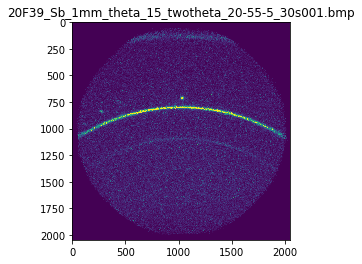

0.22119980000000003 0.096768 0.0978528 0 0.4363323129985824 0


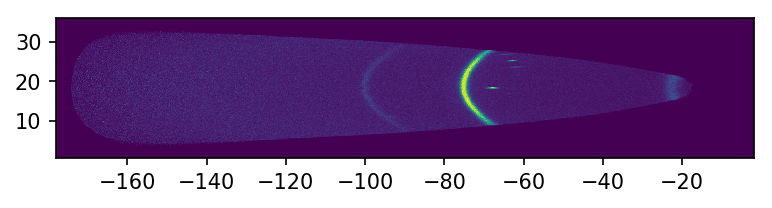

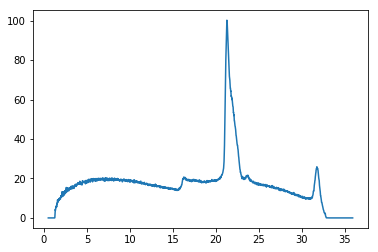

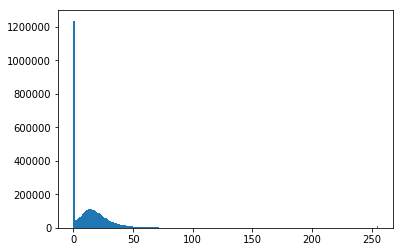

20F39_Sb_1mm_theta_15_twotheta_20-55-5_30s005.bmp
005


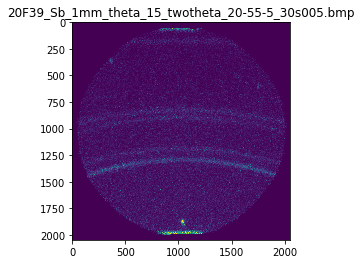

0.22119980000000003 0.096768 0.0978528 0 0.7853981633974483 0


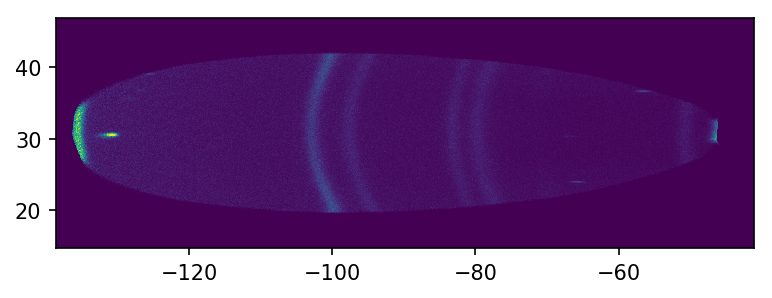

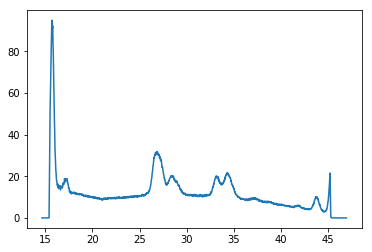

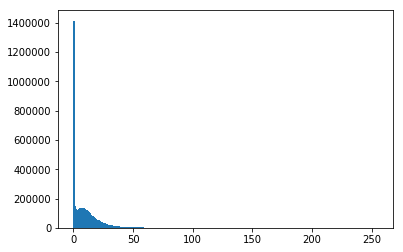

20F39_Sb_1mm_theta_15_twotheta_20-55-5_30s002.bmp
002


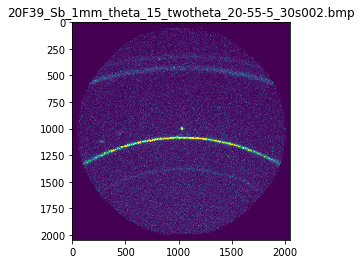

0.22119980000000003 0.096768 0.0978528 0 0.5235987755982988 0


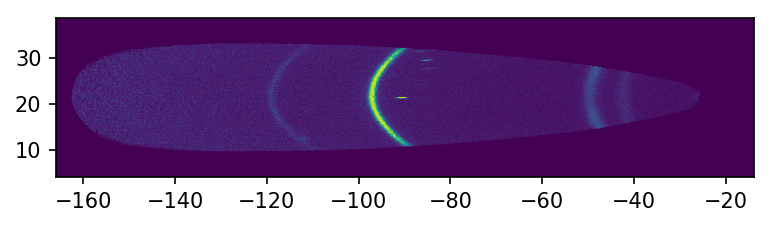

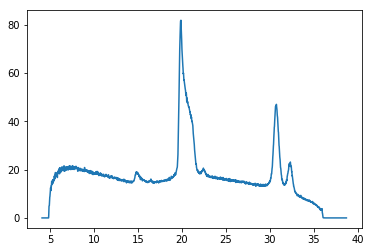

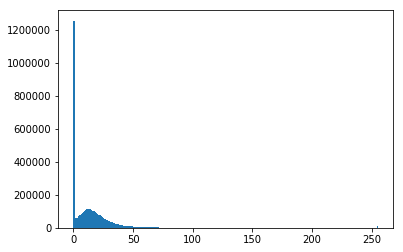

20F39_Sb_1mm_theta_15_twotheta_20-55-5_30s003.bmp
003


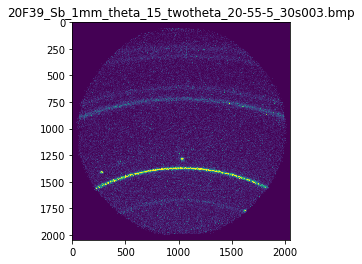

0.22119980000000003 0.096768 0.0978528 0 0.6108652381980153 0


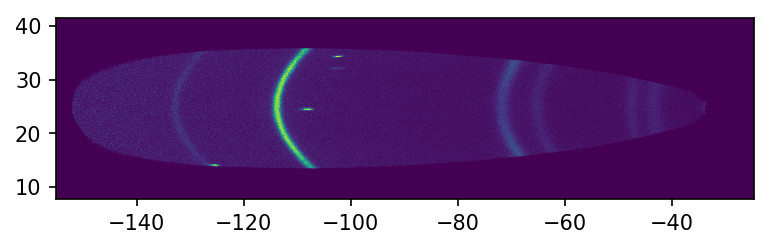

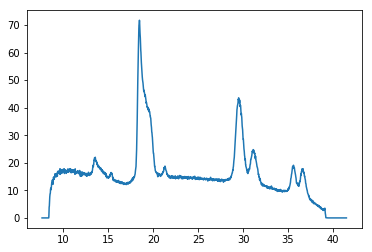

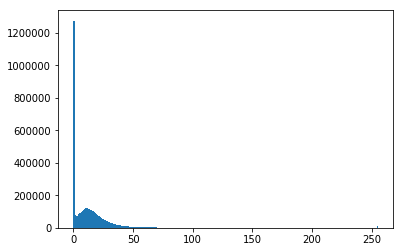

20F39_Sb_1mm_theta_15_twotheta_20-55-5_30s006.bmp
006


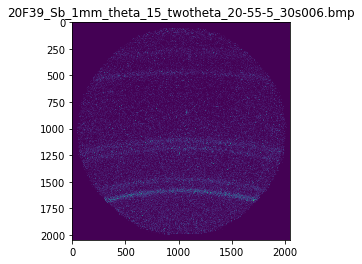

0.22119980000000003 0.096768 0.0978528 0 0.8726646259971648 0


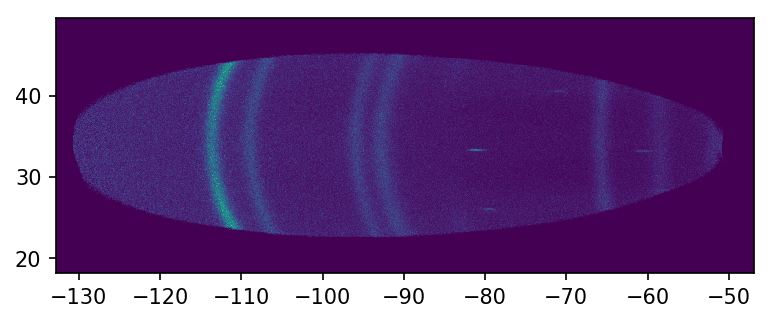

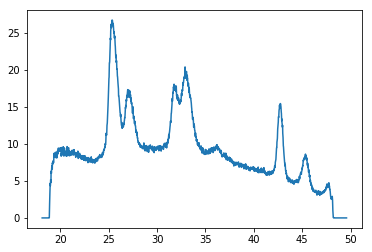

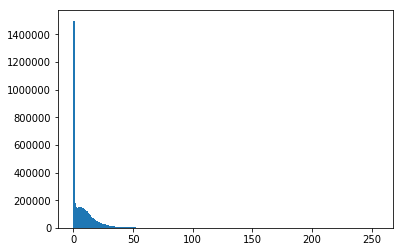

20F39_Sb_1mm_theta_15_twotheta_20-55-5_30s007.bmp
007


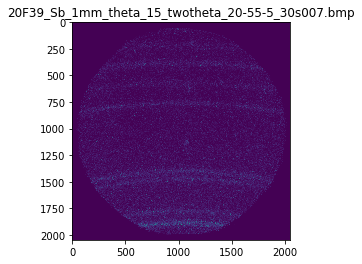

0.22119980000000003 0.096768 0.0978528 0 0.9599310885968813 0


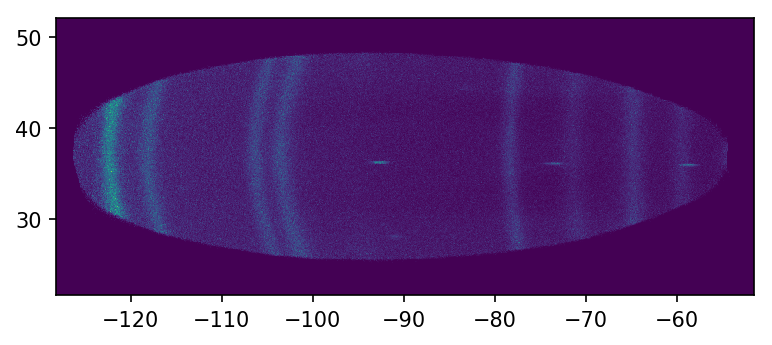

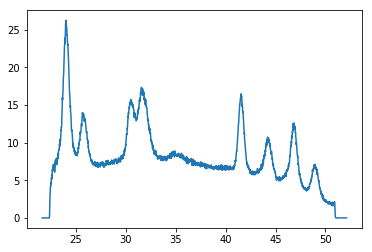

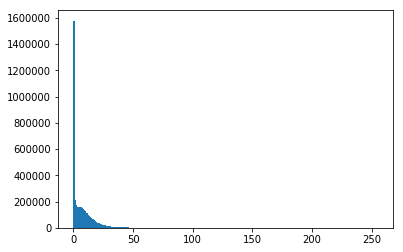

20F39_Sb_1mm_theta_15_twotheta_20-55-5_30s004.bmp
004


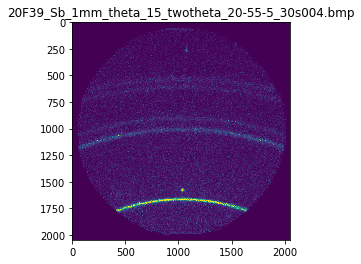

0.22119980000000003 0.096768 0.0978528 0 0.6981317007977318 0


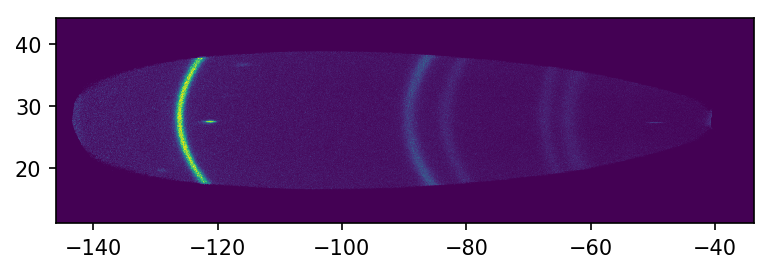

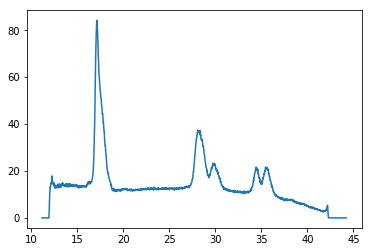

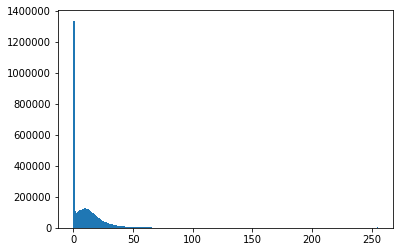

In [7]:
pths2gfrp = list(glob.glob('/home/vandover/Documents/Data/Sb/raw/*'))
meta = {}
for file in pths2gfrp:
    frame_numb = os.path.basename(file)[-8:-5]
    print(frame_numb)
    meta[frame_numb] = {}
    with codecs.open(file, 'r', encoding='utf-8',
                     errors='ignore') as fdata:
    #     print(len(fdata.read()))
        header_section = fdata.read()[:(80*96)]
        header = [header_section[i*80:(i*80+80)] for i in np.arange(96)]
    #     print(header)
        for row in header:
            key = row[:7]
            data = row[8:].strip().split()
            meta[frame_numb][key] = data
pths2bmp = list(glob.glob('/home/vandover/Documents/Data/Sb/bmps/RGB/*.bmp'))
# file = pths2bmp[0]
# raw = cv2.imread(file)
# for c in [0,1,2]:
#     plt.imshow(raw[:,:,c])
#     plt.show()
#     plt.close()
    

for file in pths2bmp:
    pars = ["dist", "poni1", "poni2", "rot1", "rot2", "rot3"]
    raw = cv2.imread(file)[:,:,0]
    name = os.path.basename(file)
#     np.save(f'/home/vandover/Documents/Data/Sb/bmps/RGB/npys/{name[:-4]}.npy',raw)
    key = name[-7:-4]
    print(name)
    print(key)
    plt.title(name)
    plt.imshow(raw)
    plt.show()
    plt.close()
    
    PONI1 = 96.0e-6*np.array(meta[key]['CENTER '],dtype=float)[2]
    PONI2 = 96.0e-6*np.array(meta[key]['CENTER '],dtype=float)[3]
    ROT2 = np.deg2rad(np.array(meta[key]['START  '],dtype=float)[0])
    DIST = np.array(meta[key]['DISTANC'],dtype=float)[1]/100
    DET = pyFAI.detectors.Detector(pixel1=96.0e-6, pixel2=96.0e-6, max_shape=(2048,2048))
    WL = np.array(meta[key]['WAVELEN'],dtype=float)
    WL = 0.5*10**-10*(WL[0]+WL[1])
    MASK = automask(raw)
    pf = [DIST,PONI1,PONI2,0,ROT2,0]
    ai = pyFAI.azimuthalIntegrator.AzimuthalIntegrator(*pf,detector=DET,wavelength=WL)
    Q1D, I1D = ai.integrate1d(raw,2048,unit="q_nm^-1", method="csr", safe=True)
    I2D, Q2D, Chi2D = ai.integrate2d(raw,2048,unit="q_nm^-1", method="csr", safe=True)
    print(*pf)
    fig,ax = plt.subplots(1,1,dpi=150)
    ax.imshow(I2D,extent=[Chi2D[0],Chi2D[-1],Q2D[0],Q2D[-1]])
#     ax[1].imshow(Chi2D)
    plt.show()
    plt.close()
    
    
    plt.plot(Q1D,I1D)
    plt.show()
    plt.close()
    
    plt.hist(raw.ravel(),bins=256)
    plt.show()
    plt.close
# key = '001'

# PONI1 = 96.0e-6*np.array(meta[key]['CENTER '],dtype=float)[0]
# PONI2 = 96.0e-6*np.array(meta[key]['CENTER '],dtype=float)[1]
# ROT2 = np.deg2rad(np.array(meta[key]['START  '],dtype=float)[0])
# DIST = np.array(meta[key]['DISTANC'],dtype=float)[1]/100
# DET = pyFAI.detectors.Detector(pixel1=96.0e-6, pixel2=96.0e-6, max_shape=(2048,20488))
# WL = np.array(meta[key]['CENTER '],dtype=float)

# pf = [DIST,PONI1,PONI2,0,ROT2,0]
# ai = pyFAI.azimuthalIntegrator.AzimuthalIntegrator(*pf,detector=DET,wavelength=WL)

# ai.integrate1d()

In [12]:
np.deg2rad(25)
np.rad2deg(0.4850075782140245)

27.788887263524778

In [15]:
import json

data = json.load(fp=open('/home/vandover/Documents/Data/18CIT49586_LaMnOx_retake/Take6/18CIT49586_LaMnOx_take6_2020-07-21_withoutDustCollector_PC.json'))
data

{'tau_250_T_600': {'PC for Optical and Spectroscopy': 0.561,
  'PC for Optical and XRD': 0.405,
  'PC for Spectroscopy and XRD': 0.188},
 'tau_300_T_600': {'PC for Optical and Spectroscopy': 0.77,
  'PC for Optical and XRD': -0.004,
  'PC for Spectroscopy and XRD': -0.167},
 'tau_350_T_600': {'PC for Optical and Spectroscopy': 0.256,
  'PC for Optical and XRD': 0.216,
  'PC for Spectroscopy and XRD': 0.246},
 'tau_400_T_600': {'PC for Optical and Spectroscopy': 0.514,
  'PC for Optical and XRD': 0.031,
  'PC for Spectroscopy and XRD': 0.114},
 'tau_450_T_600': {'PC for Optical and Spectroscopy': 0.154,
  'PC for Optical and XRD': 0.248,
  'PC for Spectroscopy and XRD': 0.184},
 'tau_500_T_600': {'PC for Optical and Spectroscopy': 0.489,
  'PC for Optical and XRD': 0.174,
  'PC for Spectroscopy and XRD': 0.374},
 'tau_550_T_600': {'PC for Optical and Spectroscopy': 0.212,
  'PC for Optical and XRD': 0.12,
  'PC for Spectroscopy and XRD': -0.196},
 'tau_600_T_600': {'PC for Optical and S

In [ ]:
fpraw = '/home/vandover/Documents/Data/Sb/20F39_Sb_1mm_theta_15_twotheta_25-55-5_45s.xy'
raw = np.genfromtxt(fpraw,skip_header=3)
tt = raw[:,0]
I = raw[:,1]
def TT2Q(span,wl = 0.15418,TT2Q=True):
    spanmin = min(span)
    spanmax = max(span)
    if TT2Q:
        newspan = 4*np.pi*np.sin(np.deg2rad(span/2))/wl
    return newspan
# plt.plot(tt,I)
Qraw = TT2Q(tt)
Q = Qraw[(Qraw>=10)&(Qraw<=45)]
I = I[(Qraw>=10)&(Qraw<=45)]
plt.plot(Q,I)

In [ ]:
for file in pths2gfrp:
    with open(file,'rb') as fdata:  
        print(len(fdata.read()))
meta

# To do

Look into the structured data format max sent

In [ ]:
def DCX_GET_CAMERA_INFO_structure_format(self):
    “”"
    Returns structure format of the camera info.
    “”"
    s_struct = “<”
    s_struct += “32s ” #Camera manufacturer
    s_struct += “32s ” #Camera model
    s_struct += “32s ” #Camera serial number
    s_struct += “32s ” #Camera version
    s_struct += “32s ” #Firmware date
    s_struct += “I ”  #Camera ID (as set in EEPROM)
    s_struct += “I ”  #Monochrome or color mode, bool??
    s_struct += “I ”  #Pixel pitch in um */
    s_struct += “d ”  #Frame rate (frames per second) */
    s_struct += “d ”  #Current exposure (ms) */
    s_struct += “d ”  #Gamma value */
    s_struct += “I ”  #Gains in non-linear range [0,100] */
    s_struct += “I ”  #red_gain, green_gain, blue_gain;
    s_struct += “I ”  #red_gain, green_gain, blue_gain;
    s_struct += “I ”  #red_gain, green_gain, blue_gain;
    s_struct += “I ”  #0,1,2,4,8 ==> disable, enable, BG40, HQ, IR Auto */
    s_struct += “d”  #color_correction_factor;
    return s_struct, struct.Struct(s_struct)


In [ ]:
196.6/2048*1000

